# Guide d'utilisation 
Pour tester notre code en temps qu'utilisateur, il faut run dans l'ordre : 
* Installations
* Configuration
* Téléchargement du dataset
* sauvegarde du fichier data.json
* Load Json
* features
* utilisateurs
* choix utilisateur sur 20 images 
* entraînement (pas tous)
* visualisation

Si on souhaite généer un faux user, on peut définir les données dans FakeUser, et lancer _Entrainement_ *'Fake'*. Il faut précédement recharger tous sauf _choix utilisateur sur 20 images_.

# Installations

In [ ]:
!pip install SPARQLWrapper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Configuration

In [ ]:
n_colors = 3

test_size = 0.2 (0.0 - 1.0)

# Téléchargement du dataset

## Récupération des données

In [ ]:
import sys
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

# Requete qui permet de récupérer les images de 300 monarques ainsi que leurs titres de noblesse, leur sexe, leur date de naissance et de mort (en anglais)
# Ces tags vont nous permettre de d'identifier au mieux les préférencesde l'utilisateur

query = """
SELECT ?monarque ?monarqueLabel ?image ?sexe_ou_genreLabel (MAX(?date_birth_)as ?date_birth) (MAX(?date_death_) as ?date_death) (GROUP_CONCAT(DISTINCT ?title; separator="; ") AS ?noble_titles)

WHERE {
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". 
  }
  ?monarque wdt:P106 wd:Q116.
  ?monarque wdt:P18 ?image.
  ?monarque wdt:P21 ?sexe_ou_genre.
  ?monarque wdt:P569 ?date_birth_.
  ?monarque wdt:P570 ?date_death_.
  ?monarque wdt:P97 ?noble_title.
  ?noble_title rdfs:label ?title FILTER( LANG(?title)="en" ).
}
GROUP BY ?monarque ?monarqueLabel ?image ?sexe_ou_genreLabel

LIMIT 300
"""



def get_results(endpoint_url, query):
  # récupère les images ainsi que leur data associées pour les stocker dans un fichier json
    user_agent = "WDQS-example Python/%s.%s" % (
        sys.version_info[0],
        sys.version_info[1],
    )
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


items = []
items_data_type = []
results = get_results(endpoint_url, query)

first = True
for result in results["results"]["bindings"]:
    tmp_array = []
    for k,v in result.items():
      if first:
        items_data_type.append(k)
      tmp_array.append(result[k]['value'])
    if first:
      first = False
    items.append(tmp_array)
print(f"Size: {len(items)}")

Size: 300


## Téléchargement des images

In [ ]:
import requests
import multiprocessing
import os
from io import BytesIO


def downloadImage(url,path,i):
  # télécharge les images à partir de de leur lien url et les stocke soit dans le fichier data.json soit dans le dossier images
  headers = {'User-Agent': 'CoolBot/0.0 (https://example.org/coolbot/; coolbot@example.org)'}
  response = requests.get(url, stream = True, headers = headers)
  img = Image.open(BytesIO(response.content))
  width, height = img.size
  sz_max = 720
  if width*height > sz_max*sz_max:
    if width > height:
      height = int(height*(sz_max/width))
      width = sz_max
    else:
      width = int(width*(sz_max/height))
      height = sz_max
    img = img.resize((width, height))
  img = img.convert("RGB")
  img.save(path)
  # with open(path, 'wb') as localFile:
  #   localFile.write(response.content)

In [ ]:
# Mettre à True pour télécharger les images et lier leur chemin. <= On fonctionnera uniquement avec ça pour le moment, afin d'alléger le fichier data.json
# Mettre False pour directement les stocker dans le fichier data.json 
image_download_file = True

import numpy as np
import requests
import io
import matplotlib.pyplot as plt 
import os
import multiprocessing
from multiprocessing import cpu_count
import time

start_time_ms = int(round(time.time() * 1000))

save_folder_images = "images"
# Vérifie si le dossier existe
if not os.path.exists(save_folder_images):
# Crée le dossier s'il n'existe pas
  os.makedirs(save_folder_images)
  print("Le dossier\"", save_folder_images, "\"a été créé avec succès.")
else:
  print("Le dossier\"", save_folder_images, "\"existe déjà.")
labels_all = [] 
print(f"Téléchargement de {len(items)} images.")
if image_download_file:
  items_data_type.insert(3, "image_path")
else:
  items_data_type.insert(3, "numpy_image")
queue = []
for i,item in enumerate(items):
  path = f"{save_folder_images}/"+(str(hash(item[2].split("/")[len(item[2].split("/"))-1])))+".jpg"
  queue.append([item[2],path,i])
  item.insert(3,path)
processList = []
# for task in queue:
#   downloadImage(task[0],task[1],task[2])
with multiprocessing.Pool(processes=4) as pool:
    pool.starmap(downloadImage, queue)
print(f"Fin du téléchargement en {round((int(round(time.time() * 1000))-start_time_ms)/1000,2)}s")

Le dossier" images "a été créé avec succès.
Téléchargement de 300 images.


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (93439870 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Fin du téléchargement en 99.6s


# Pré-traitement

## Titres de noblesse

In [ ]:

def titles_traitement(item):
  # récupère les différents titres de noblesse
  item[len(item)-1] = item[len(item)-1].split("; ")
  return item

In [ ]:
for item in items:
  item = titles_traitement(item)

## Années

In [ ]:
from datetime import datetime
import math


def years_traitement(item):
  # récupère les dates de naissance et de mort pour retourner les siècles auquels a appartenu le monarque
  date_birth_index = items_data_type.index('date_birth')
  date_death_index = items_data_type.index('date_death')
  date_str = item[date_birth_index]
  
  siecle_birth = 1
  if date_str.startswith("-"):
    siecle_birth = -1
    date_str = date_str[1:]
  try:
    siecle_birth *= math.ceil(datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%SZ").year/100)
    date_str = item[date_birth_index]
  except:
    siecle_birth = None
    print(f"{date_str} n'est pas une date")

  siecle_death = 1
  if date_str.startswith("-"):
    siecle_death = -1
    date_str = date_str[1:]
  try:
    siecle_death *= math.ceil(datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%SZ").year/100)
  except:
    siecle_death = None
    print(f"{date_str} n'est pas une date")
  
  item.pop(date_death_index)
  item.pop(date_birth_index)
  if not siecle_death and not siecle_birth:
    item.append([])
    return item
  if not siecle_death:
    siecle_death = siecle_birth
  else:
    siecle_birth = siecle_death
  if siecle_birth != siecle_death:
    item.append([siecle_birth,siecle_death])
  else:
    item.append([siecle_birth])
  return item

In [ ]:
if not "siecles" in items_data_type:
  items_data_type.append('siecles')
  for item in items:
    item = years_traitement(item)
  items_data_type.remove('date_birth')
  items_data_type.remove('date_death')

http://www.wikidata.org/.well-known/genid/4632eae2fc7522ee29f532b339978e38 n'est pas une date
http://www.wikidata.org/.well-known/genid/4632eae2fc7522ee29f532b339978e38 n'est pas une date
http://www.wikidata.org/.well-known/genid/35b5eb19120674aa5de3872b9dcacb1a n'est pas une date
http://www.wikidata.org/.well-known/genid/35b5eb19120674aa5de3872b9dcacb1a n'est pas une date
http://www.wikidata.org/.well-known/genid/313bb233f066bdd73a436ebebea4be82 n'est pas une date
http://www.wikidata.org/.well-known/genid/313bb233f066bdd73a436ebebea4be82 n'est pas une date


## Orientation de l'image

In [ ]:
from PIL import Image

def get_orientation(image_path) :
  # recoit l'image et retourne l'orientation en str ["carré", "portrait", "paysage"]
  orientation = ""
  img = Image.open(image_path)
  width,height = img.size

  if abs(height - width) < 50 :
    orientation = "carré"
  elif height > width :
    orientation = "portrait"
  else : 
    orientation = "paysage"

  return orientation

In [ ]:
if not "image_orientation" in items_data_type:
  items_data_type.insert(3, "image_orientation")
  for i,item in enumerate(items):
    item.insert(3,get_orientation(item[3]))

## Couleurs prédominantes 

In [ ]:
from PIL import Image
import numpy as np
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import math
  
def get_predominant_colors(numarray, n_colors=5):
  # utilise le module MiniBatchKmeans pour renvoyer les 5 couleurs prédominantes d'une image 
  X = []
  Y = []
  clusters = MiniBatchKMeans(n_clusters=n_colors, n_init=2)
  clusters.fit(numarray)
  npbins = np.arange(0, n_colors+1)
  histogram = np.histogram(clusters.labels_, bins=npbins)
  labels = np.unique(clusters.labels_)
  colors = []
  for i in range(n_colors):
    colors.append([math.ceil(clusters.cluster_centers_[i][0]), math.ceil(clusters.cluster_centers_[i][1]), math.ceil(clusters.cluster_centers_[i][2])])
  return [(np.array(histogram[0])/np.sum(histogram[0])).tolist(), colors]

In [ ]:
import time
import multiprocessing

def perform_item(item, i, affichage = False):
  global n_colors
  start_time_ms = int(round(time.time() * 1000))
  imgfile = Image.open(item[items_data_type.index("image_path")-1])
  numarray = np.array(imgfile.getdata(), np.uint8)
  if type(numarray[0]) == np.uint8:
    # Utiliser la fonction repeat pour répéter chaque élément trois fois
    b = np.repeat(numarray, 3)
    # Utiliser la fonction reshape pour changer la forme de l'array
    numarray = b.reshape(len(numarray), 3)
    
  colors = get_predominant_colors(numarray,n_colors=n_colors)
  item.insert(3,colors)
  if affichage:
    plt.figure(i+100000)
    plt.suptitle(f"{i}: {(int(round(time.time() * 1000))-start_time_ms)/1000}s")
    plt.subplot(121)
    plt.imshow(imgfile)
    plt.subplot(122)
    barlist = plt.bar(range(n_colors), colors[0])
    for j, color in enumerate(colors[1]):
      barlist[j].set_color("#%02x%02x%02x" % (color[0], color[1], color[2]))
    plt.show()
  print(f"{i}: {(int(round(time.time() * 1000))-start_time_ms)/1000}s")



affichage = False
if not "predominant_colors" in items_data_type:
  items_data_type.insert(3, "predominant_colors")
  begin_time_ms = int(round(time.time() * 1000))
  for i, item in enumerate(items):
    perform_item(item,i,affichage)
  print(f"Total: {(int(round(time.time() * 1000))-begin_time_ms)/1000}s")

0: 0.272s
1: 0.46s
2: 0.361s
3: 0.152s
4: 0.661s
5: 0.263s
6: 0.471s
7: 0.314s
8: 0.391s
9: 0.301s
10: 0.436s
11: 0.309s
12: 0.687s
13: 2.047s
14: 0.168s
15: 0.43s
16: 0.228s
17: 0.391s
18: 0.709s
19: 0.543s
20: 0.318s
21: 0.455s
22: 0.307s
23: 0.393s
24: 0.537s
25: 0.439s
26: 0.265s
27: 0.275s
28: 0.305s
29: 0.621s
30: 0.42s
31: 0.148s
32: 0.264s
33: 0.156s
34: 0.199s
35: 0.598s
36: 0.277s
37: 0.331s
38: 0.435s
39: 0.361s
40: 0.51s
41: 2.49s
42: 0.091s
43: 0.332s
44: 0.275s
45: 0.438s
46: 0.43s
47: 0.4s
48: 0.27s
49: 0.456s
50: 0.49s
51: 0.274s
52: 0.76s
53: 0.537s
54: 0.366s
55: 0.228s
56: 0.507s
57: 0.322s
58: 0.714s
59: 0.544s
60: 0.388s
61: 0.227s
62: 0.527s
63: 0.666s
64: 0.531s
65: 0.155s
66: 2.608s
67: 0.418s
68: 0.423s
69: 0.161s
70: 0.641s
71: 0.346s
72: 0.379s
73: 0.342s
74: 0.464s
75: 0.346s
76: 0.336s
77: 0.285s
78: 0.454s
79: 0.231s
80: 0.273s
81: 0.542s
82: 0.27s
83: 0.393s
84: 0.568s
85: 0.354s
86: 0.363s
87: 0.464s
88: 0.631s
89: 0.465s
90: 0.066s
91: 0.276s
92: 0.219s

# Sauvegarde du fichier data.json

In [ ]:
import json
import uuid
# Génère un uuid pour chaque image et l'ajoute dans le fichier data.json
items_data_type.insert(0,"uuid")
print(items_data_type)
save_dic = {}
save_dic['items'] = []
for item in items:
  item.insert(0,str(uuid.uuid4()))
  tmp_dic = {}
  for j in range(len(items_data_type)):
      tmp_dic[items_data_type[j]] = item[j]
  save_dic['items'].append(tmp_dic)
with open("data.json", "w") as f:
    # Écrire le dictionnaire dans le fichier en format JSON
    json.dump(save_dic, f)

['uuid', 'monarque', 'monarqueLabel', 'image', 'predominant_colors', 'image_orientation', 'image_path', 'sexe_ou_genreLabel', 'noble_titles', 'siecles']
['6d7e3ebb-a0bf-4f6d-b6c3-e2e179fd3f70', 'http://www.wikidata.org/entity/Q170398', 'Wilhelm I of Württemberg', 'http://commons.wikimedia.org/wiki/Special:FilePath/K%C3%B6nig%20Wilhelm%20I%20W%C3%BCrtt.jpg', [[0.46138203017832646, 0.16742455418381344, 0.37119341563786007], [[41, 55, 47], [181, 136, 111], [97, 88, 86]]], 'portrait', 'images/-2523203003635729445.jpg', 'male', ['king'], [18]]
{'uuid': '6d7e3ebb-a0bf-4f6d-b6c3-e2e179fd3f70', 'monarque': 'http://www.wikidata.org/entity/Q170398', 'monarqueLabel': 'Wilhelm I of Württemberg', 'image': 'http://commons.wikimedia.org/wiki/Special:FilePath/K%C3%B6nig%20Wilhelm%20I%20W%C3%BCrtt.jpg', 'predominant_colors': [[0.46138203017832646, 0.16742455418381344, 0.37119341563786007], [[41, 55, 47], [181, 136, 111], [97, 88, 86]]], 'image_orientation': 'portrait', 'image_path': 'images/-2523203003

**------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# Load Json

## Fonction filtrage

In [ ]:
import random
import math

def shuffleList(lst):
  l = list(lst)
  random.shuffle(l)
  return l

def filter_data(items_data, amount=-1, excludes=[], not_titles = [], titles = [],siecles=[], orientations=[], sexes = [], not_siecles=[], not_orientations=[], not_sexes = []):
  items_fil = [i for i in items_data.copy() if i not in excludes]

  # not_siecles
  if not_siecles:
    items_tmp = items_fil.copy()
    for item in items_tmp:
      contains = False
      for siecle in not_siecles:
        if siecle in item['siecles']:
          contains = True
      if contains:
        items_fil.remove(item)
  # siecles
  if siecles:
    items_tmp = items_fil.copy()
    for item in items_tmp:
      contains = False
      for siecle in siecles:
        if siecle in item['siecles']:
          contains = True
      if not contains:
        items_fil.remove(item)

  # not_titles
  if not_titles:
    items_tmp = items_fil.copy()
    for item in items_tmp:
      contains = False
      for title in not_titles:
        if title in item['noble_titles']:
          contains = True
      if not contains:
        items_fil.remove(item)
  # titles
  if titles:
    items_tmp = items_fil.copy()
    for item in items_tmp:
      contains = False
      for title in titles:
        if title in item['noble_titles']:
          contains = True
      if not contains:
        items_fil.remove(item)

  # not_orientations
  if not_orientations:
    items_tmp = items_fil.copy()
    for item in items_tmp:
      contains = False
      for orientation in not_orientations:
        if orientation == item['image_orientation']:
          contains = True
          break
      if contains:
        items_fil.remove(item)
  # orientations
  if orientations:
    items_tmp = items_fil.copy()
    for item in items_tmp:
      contains = False
      for orientation in orientations:
        if orientation == item['image_orientation']:
          contains = True
      if not contains:
        items_fil.remove(item)

  # not_sexes
  if not_sexes:
    items_tmp = items_fil.copy()
    for item in items_tmp:
      contains = False
      for sexe in not_sexes:
        if sexe == item['sexe_ou_genreLabel']:
          contains = True
          break
      if contains:
        items_fil.remove(item)
  # sexes
  if sexes:
    items_tmp = items_fil.copy()
    for item in items_tmp:
      contains = False
      for sexe in sexes:
        if sexe == item['sexe_ou_genreLabel']:
          contains = True
      if not contains:
        items_fil.remove(item)
  while amount != -1 and amount < len(items_fil):
    items_fil.pop(0)
  return items_fil

## Import

In [ ]:
import json

def json_load():
  with open('data.json') as mon_fichier:
    data = json.load(mon_fichier)
  return data

items_data = json_load()['items']

carré_hommes_paysage=filter_data(shuffleList(items_data),siecles=[13,14,15,16,17,18,19,20], titles = ['king','queen','duke'])

carré_hommes_paysage_train = filter_data(carré_hommes_paysage,amount=len(carré_hommes_paysage)*(1-test_size))
carré_hommes_paysage_test = filter_data(carré_hommes_paysage, excludes=carré_hommes_paysage_train)

others=filter_data(shuffleList(items_data), excludes=carré_hommes_paysage)

complement_carré_hommes_paysage_train=filter_data(others,amount=len(carré_hommes_paysage_train), excludes=carré_hommes_paysage)
complement_carré_hommes_paysage_test=filter_data(others, excludes=complement_carré_hommes_paysage_train)

print(len(carré_hommes_paysage))
print(len(others))
print(len(carré_hommes_paysage_train))
print(len(complement_carré_hommes_paysage_train))
print(len(carré_hommes_paysage_test))
print(len(complement_carré_hommes_paysage_test))
print(len(filter_data(shuffleList(items_data))))

71
229
56
56
15
173
300


# Features

In [ ]:
import numpy as np

def getAllTitles(items_data):
  titles = {}
  for item in items_data:
    for title in item['noble_titles']:
      titles[title] = 1 if not title in titles else titles[title]+1
  print(titles)
  return list(titles)


# Création du label des inputs du model
feature_labels = []
for i in range(0,3):
  feature_labels.append(f'Color{i}R')
  feature_labels.append(f'Color{i}G')
  feature_labels.append(f'Color{i}B')
feature_labels.extend(["format"]) # 1 = paysage 0 = carré -1 = portrait
feature_labels.append(f'Sexe ou Genre')
titles_labels = getAllTitles(items_data)
feature_labels.extend(titles_labels)
siecle_labels = range(-21,21)
feature_labels.extend(siecle_labels)
for i,f in enumerate(feature_labels):
  feature_labels[i] = f"[{i}]{f}"
print(f"Nombre de feature: {len(feature_labels)} -> {feature_labels}")



def itemToFeature(item):
  feature = []

  # Couleurs: predominant_colors
  # In:  (n_colors,3)
  # Out: (n_colors*3,)
  for color in item['predominant_colors'][1]:
    for d in color:
      # Normalisation entre 0 et 1
      feature.append(d/255.0)

  # Orientation de l'image: image_orientation
  # In:   1 = paysage 0 = carré -1 = portrait
  # Out: (1,)
  orientation_feature = [1,-1,0]
  orientation_lables = ["portrait", "paysage", "carré"]
  feature.append(orientation_feature[orientation_lables.index(item['image_orientation'])])

  # Sexe ou Genre: sexe_ou_genreLabel
  # In:  male or female
  # Out:   0  or   1
  if item['sexe_ou_genreLabel'] == 1:
    feature.append(1)
  else:
    feature.append(0)

  # Titres: 
  # In: (?,)
  # Out: (len(titles_labels),)
  global titles_labels
  titres_feature = [0]*len(titles_labels)
  for titre in item['noble_titles']:
    titres_feature[titles_labels.index(titre)] = 1
  feature.extend(titres_feature)

  global siecle_labels
  siecles_feature = [0]*len(siecle_labels)
  for siecle in item['siecles']:
    siecles_feature[siecle_labels.index(siecle)] = 1
  feature.extend(siecles_feature)
  return feature

features = []
for item in items_data:
  features.append(itemToFeature(item))
print(f"features: {np.array(features).shape}")

{'king': 70, 'margrave': 8, 'Holy Roman Emperor': 3, 'consort king of Sicily': 2, 'pharaoh': 9, 'Shah': 1, 'King of Jerusalem': 5, 'Duke of Calabria': 1, 'Count of Guise': 1, 'Duke of Anjou': 3, 'Duke of Bar': 1, 'Duke of Lorraine': 1, 'King of Naples': 2, 'Count of Provence and Forcalquier': 1, 'Emperor of Japan': 5, 'Roman emperor': 2, 'Custodian of the Two Holy Mosques': 1, 'Prince of Monaco': 1, 'count': 11, 'monarch of Scotland': 5, 'Tsar of All Russia': 35, 'King of France': 4, 'King of Navarre': 3, 'King of Galicia': 2, 'Infante of Aragón': 1, 'King of Sardinia': 2, 'King of Castile': 3, 'King of Toledo': 1, 'Lord of Molina': 2, 'king of Granada': 2, 'King of Seville': 1, 'King of Jaen': 1, 'King of Murcia': 1, 'King of León': 3, 'king of Franks': 24, 'king of Aquitaine': 4, 'king of Lotharingia': 2, 'emperor': 7, 'queen consort': 7, 'queen regnant': 9, 'duke': 50, 'monarch of Italy': 8, 'emperor of the Occident': 6, 'princess': 10, 'List of counts of Paris': 1, 'queen consort o

# Utilisateurs

In [ ]:
# Si plusieurs utilisateurs. Ici nous n'en utilisons que 1
users_data = []
# Permet de stocker si un utilisateur aime ou non une image
user1 = {'reviews':{}}

def getUserFeatures(user, items_data):
  features = []
  y = []
  for item in items_data:
    if item['uuid'] in user['reviews']:
      features.append(itemToFeature(item))
      y.append(1 if user['reviews'][item['uuid']] else 0)
  return [features,y]

# Fake user

In [ ]:
def item_data_fake(items, fake=True):
  # crée un modèle de préférence prédéfini pour un faux utilisateur pour tester le modèle d'exploitation
  fake_dic = {}
  for item in items:
    fake_dic[item['uuid']] = fake
  return fake_dic
user1['reviews'].update(item_data_fake(carré_hommes_paysage_train))
user1['reviews'].update(item_data_fake(complement_carré_hommes_paysage_train,False))
print(len(user1['reviews']))

112


# Selection des premières images de l'utilisateur

## Random item 


In [ ]:
import random
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def random_item(user, data, never_view = False):
  # retourne une image aléatoire de la base de donnée
  sz = len(data)
  r = random.randint(0, sz-1)
  if never_view:
    while data[r]['uuid'] in user:
      r = random.randint(0, sz-1)
  return data[r]

#random_item(user1, items_data)

## Choix Utilisateur sur 20 images


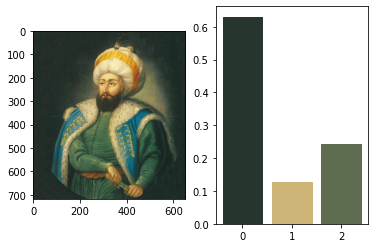

image_orientation:  portrait
sexe_ou_genreLabel:  male
siecles:  [15]


KeyboardInterrupt: ignored

In [ ]:
import json
from PIL import Image
import time

def user_choice(user,items_data,amount = 20):
  # propose 20 images aléatoire à l'utilisateur en affichant également les tags tels que l'orientation, le sexe et les siècles ainsi que les couleurs prédominantes 
  # retourne un dictionnaire avec les uuid et le choix de l'utilisateur pour chacune des 20 images associées
  my_dic = {}
  for w in range(amount):
    item = random_item(user1,items_data,True)
    id = item['uuid']
    fig = plt.figure(100+w)
    plt.subplot(121)
    plt.imshow(Image.open(item['image_path']))
    plt.subplot(122)
    colors =  item['predominant_colors'][1]
    barlist = plt.bar(range(len(colors)), item['predominant_colors'][0])
    for i, color in enumerate(colors):
      barlist[i].set_color("#%02x%02x%02x" % (color[0], color[1], color[2]))
    plt.show()
    time.sleep(1)
    print("image_orientation: ",item['image_orientation'])
    print("sexe_ou_genreLabel: ",item['sexe_ou_genreLabel'])
    print("siecles: ",item['siecles'])
    user_choice = None
    while user_choice == None:
      user_choice = input("Aimez-vous cette image ? (yes/no): ")
      if user_choice in {"O", "o", "oui", "Oui", "OUI", "y", "Y", "yes", "Yes", "YES"}:
        user_choice = True
      elif user_choice in {"n","N","No","no","non","NON"}:
        user_choice = False
      else:
        user_choice = None
    print(f"Votre choix: {user_choice}")
    my_dic[id] = user_choice
  return my_dic

my_dico = user_choice(user1, items_data,amount=10)
user1['reviews'].update(my_dico)

# Entrainement

In [ ]:
from collections import defaultdict
history_pack = defaultdict(list)

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import RMSprop

def getModelOfUser(user):
  # Crée un modèle de réseau de neuronnes avec une couche d'entrée qui récupère les paramètres, une couche intermédiare et une couche de sortie 
  # Définition du modèle
  model = Sequential()
  # model.add(Dense(len(feature_labels), input_dim=len(feature_labels), activation='relu'))
  model.add(Dense(128,input_shape=(len(feature_labels),) ,activation='relu'))
  model.add(Dense(64 ,activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.003), metrics=['accuracy'])
  if "weights" in user:
    model.set_weights(user['weights'])
  model.build()
  return model

def setUpdateModelOfUser(user, model):
  user['weights'] = model.get_weights()

def trainModel(user, amount = 10):
  # entraîne le modèle sur un nombre défini d'images et le nombre de génération à entraîner
  global items_data
  model = getModelOfUser(user)
  features = getUserFeatures(user1,items_data)
  X_train = np.array(features[0])
  y_train = np.array(features[1])
  model.fit(X_train, y_train, epochs=amount, batch_size=1, verbose=0)
  setUpdateModelOfUser(user,model)

In [ ]:
trainModel(user1)
model = getModelOfUser(user1)
amount=6
# affiche l'entraînement du modèle ainsi que ses résultats 
for am in range(amount):
  my_dico = user_choice(user1, items_data, amount=1)
  print("Résultat: ")
  current_reviews_items = []
  for item in items_data:
    if item['uuid'] in my_dico:
      current_reviews_items.append(item)
      pred = model.predict([itemToFeature(item)],verbose=0)
      print(f"{item['uuid']}: {my_dico[item['uuid']]}, Pred: {(pred[0]>0.5)} ({pred})")
  user1['reviews'].update(my_dico)
  
  features = getUserFeatures({'reviews':my_dico}, items_data)
  X_train = features[0]
  y_train = features[1]
  model.fit(X_train, y_train, epochs=amount, batch_size=1, verbose=0)
  setUpdateModelOfUser(user1,model)

## Entrainement "Fake"

In [ ]:
# affiche le nombre de paramètres générés aux différentes couches ainsi que les résultats et la progression de chaque génération
model = getModelOfUser(user1)
model.summary()
features = getUserFeatures(user1,items_data)
X_train = np.array(features[0])
y_train = np.array(features[1])

user2 = {'reviews':{}}
user2['reviews'].update(item_data_fake(carré_hommes_paysage_test,fake=True))
user2['reviews'].update(item_data_fake(complement_carré_hommes_paysage_test,fake=False))

features_test = getUserFeatures(user2,items_data)
X_test = np.array(features_test[0])
y_test = np.array(features_test[1])
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
history = model.fit(X_train, y_train, epochs=10, batch_size=1, validation_data=(X_test,y_test), verbose=1)
for k,v in history.history.items():
  if not k in history_pack:
    history_pack[k] = v
  else:
    history_pack[k].extend(v)
# setUpdateModelOfUser(user1,model)

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_150 (Dense)           (None, 128)               28544     
                                                                 
 dense_151 (Dense)           (None, 64)                8256      
                                                                 
 dense_152 (Dense)           (None, 1)                 65        
                                                                 
Total params: 36,865
Trainable params: 36,865
Non-trainable params: 0
_________________________________________________________________
(112, 222)
(112,)
(188, 222)
(188,)
Epoch 1/10
112/112 [==============================] - 1s 6ms/step - loss: 0.5300 - accuracy: 0.7857 - val_loss: 0.4320 - val_accuracy: 0.7500
Epoch 2/10
112/112 [==============================] - 0s 4ms/step - loss: 0.2209 - accuracy: 0.9286 - val_loss: 0.1890 - val_accuracy: 

## Autre méthode d'entrainement (moins efficace pour généraliser)

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
model = getModelOfUser(user1)
# Définition du nombre de folds
k = 5

# Définition des folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialisation des listes pour stocker les résultats
train_scores = []
val_scores = []

# Boucle sur les folds
for train_index, val_index in kf.split(X_train):
    # Séparation des données en ensembles d'entraînement et de validation
    X_t, y_t = X_train[train_index], y_train[train_index]
    X_val, y_val = X_train[val_index], y_train[val_index]
    # Compilation et entraînement du modèle sur l'ensemble d'entraînement
    history = model.fit(X_t, y_t, epochs=2, batch_size=1, verbose=0)
    for k,v in history.history.items():
      if not k in history_pack:
        history_pack[k] = v
      else:
        history_pack[k].extend(v)
    # Évaluation du modèle sur l'ensemble d'entraînement
    train_score = model.evaluate(X_t, y_t, verbose=0)
    train_scores.append(train_score[1])
    
    # Évaluation du modèle sur l'ensemble de validation
    val_score = model.evaluate(X_val, y_val, verbose=0)
    val_scores.append(val_score[1])
    print(f">{len(train_scores)}, {train_score[1]}, {val_score[1]}")
    
# Calcul des moyennes des scores d'entraînement et de validation
train_score_mean = np.mean(train_scores)
val_score_mean = np.mean(val_scores)

print(f"Moyenne des scores d'entraînement : {train_score_mean:.2f}")
print(f"Moyenne des scores de validation : {val_score_mean:.2f}")

>1, 1.0, 0.8333333134651184
>2, 1.0, 0.6666666865348816
>3, 1.0, 1.0
>4, 1.0, 1.0
>5, 1.0, 1.0
Moyenne des scores d'entraînement : 1.00
Moyenne des scores de validation : 0.90


# Affichage

## Matrice de confusion

6/6 [==============================] - 0s 2ms/step


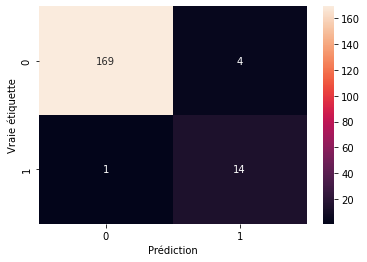

In [ ]:
user2 = {'reviews':{}}
user2['reviews'].update(item_data_fake(carré_hommes_paysage_test,fake=True))
user2['reviews'].update(item_data_fake(complement_carré_hommes_paysage_test,fake=False))

features_test = getUserFeatures(user2,items_data)
X_test = np.array(features_test[0])
y_test = np.array(features_test[1])

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.evaluate(X_test,y_test)
# Obtenir les prédictions sur l'ensemble de test
y_pred = model.predict(X_test)
y_pred_classes = np.around(y_pred)

# Calculer la matrice de confusion
confusion_mtx = confusion_matrix(y_test, y_pred_classes)

# Afficher la matrice de confusion
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.xlabel('Prédiction')
plt.ylabel('Vraie étiquette')
plt.show()

## Layer activation

10/10 [==============================] - 0s 2ms/step
(300, 128)
1: [108]Grand Duchess = 1.0
2: [36]King of Sardinia = 0.8994810581207275
3: [43]King of Murcia = 0.8569521903991699
4: [6]Color2R = 0.8560295104980469
5: [16]Shah = 0.7841790914535522
6: [60]Electress = 0.7336134314537048
7: [41]King of Seville = 0.72223961353302
8: [38]King of Toledo = 0.7218095064163208
9: [114]British Princess = 0.7157000303268433
10: [1]Color0G = 0.7132418751716614
11: [47]king of Lotharingia = 0.6830560564994812
12: [127]Lord = 0.6511366963386536
13: [103]Lord High Steward of Scotland = 0.6314586400985718
14: [40]king of Granada = 0.6301383376121521
15: [75]Crown Prince of Japan = 0.6259298920631409
16: [95]Crown Prince of Serbia = 0.618525505065918
17: [34]King of Galicia = 0.6077040433883667
18: [12]margrave = 0.6075831651687622
19: [89]king of Salian Franks = 0.5995631217956543
20: [78]Duke of Brabant = 0.5883204340934753
21: [84]Archduke of Austria = 0.5865581035614014
22: [125]prince = 0.57569515

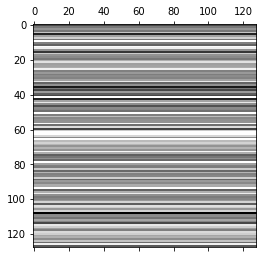

In [ ]:
import matplotlib.pyplot as plt
from keras.models import Model
user2 = {'reviews':{}}
user2['reviews'].update(item_data_fake(items_data.copy(),fake=True))

features_test = getUserFeatures(user2,items_data)
X_all = np.array(features_test[0])
# On définit la couche dont on souhaite visualiser les activations
layer_idx = 0

# On crée un nouveau modèle qui renvoie les sorties de cette couche
intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[layer_idx].output)

# On prédit les sorties de la couche pour une entrée donnée
activations = intermediate_layer_model.predict(X_all)
print(activations.shape)
# Sélectionner les activations pour le premier exemple
activations_exemple1 = activations[0, :]
activations_exemple1 = np.mean(activations,axis=0)
activations_exemple1 = 255*(1-activations_exemple1/np.max(activations_exemple1))
# Redimensionner les activations pour les visualiser sous forme de matrice carrée
ll = len(activations_exemple1)
activations_exemple2 = np.repeat(activations_exemple1,ll)
activations_exemple2 = activations_exemple2.reshape(ll, ll)
# On affiche les activations sous forme de graphique
plt.matshow(activations_exemple2, cmap='gray')
index = []
for i, n in enumerate(activations_exemple1):
    index.append(i)
iv = (1-(activations_exemple1/255))
nombres_tries = sorted(iv, reverse=True)
index_tries = [index[i] for i in sorted(range(len(nombres_tries)), key=lambda k: iv[k], reverse=True)]
for j,i in enumerate(index_tries):
  if iv[i] > 0:
    print(f'{j+1}: {feature_labels[i]} = {iv[i]}')

## SHAR

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Permutation explainer: 301it [00:22,  7.49it/s]                         


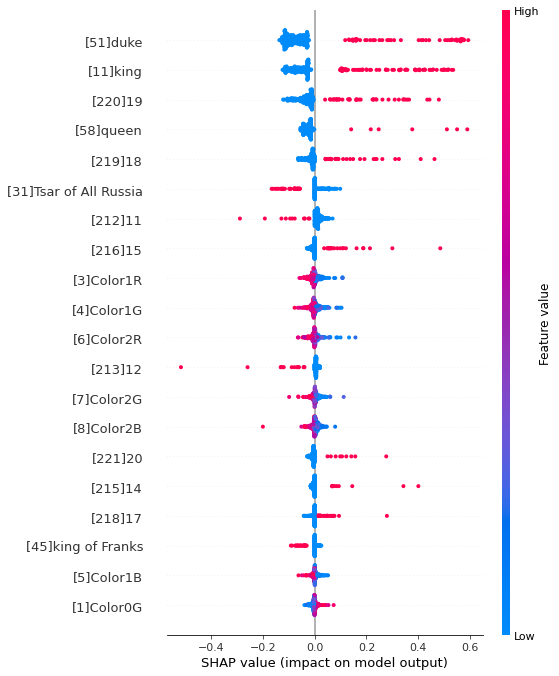

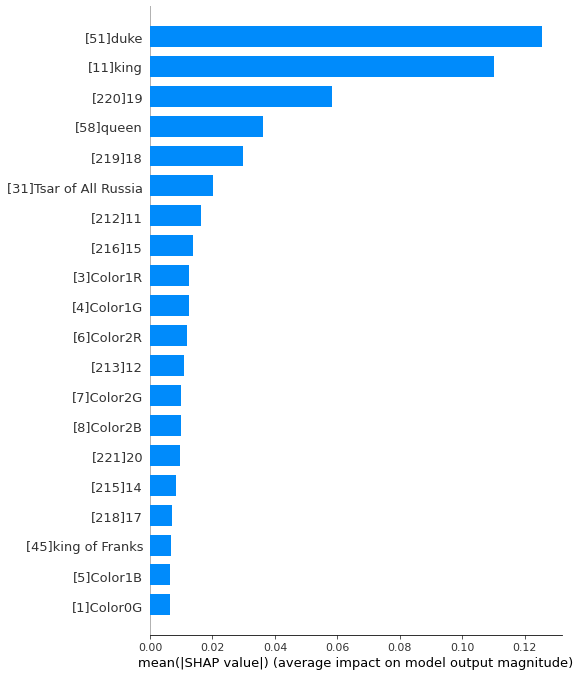

In [ ]:
import shap

# X est notre jeu de données
explainer = shap.Explainer(model, X_all)
shap_values = explainer(X_all)

# On affiche les contributions de chaque feature
shap.summary_plot(shap_values, X_all,feature_names=feature_labels)
shap.summary_plot(shap_values, X_all, plot_type="bar", feature_names=feature_labels)


## Visualisation entrainement (epochs)

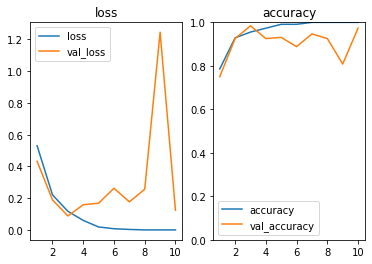

In [ ]:
import matplotlib.pyplot as plt
plt.figure(5)
epochs_labels=list(range(1,1+len(history_pack['loss'])))
ax = plt.subplot(121)
ax.set_title("loss")
plt.plot(epochs_labels,history_pack['loss'], label="loss")
plt.plot(epochs_labels,history_pack['val_loss'], label="val_loss")
plt.legend()
ax = plt.subplot(122)
ax.set_title("accuracy")
plt.plot(epochs_labels,history_pack['accuracy'], label="accuracy")
plt.plot(epochs_labels,history_pack['val_accuracy'], label="val_accuracy")
plt.legend()
plt.ylim([0,1])
plt.show()

#Zip Images

In [ ]:
!zip -r images.zip images

  adding: images/ (stored 0%)
  adding: images/2597283060364011604.jpg (deflated 1%)
  adding: images/-8446713910438092874.jpg (deflated 0%)
  adding: images/2744254947821479799.jpg (deflated 1%)
  adding: images/-7227748346257926322.jpg (deflated 1%)
  adding: images/5025558901783680901.jpg (deflated 0%)
  adding: images/5145750326386923201.jpg (deflated 0%)
  adding: images/-4525597619811181558.jpg (deflated 1%)
  adding: images/-549468015141842134.jpg (deflated 1%)
  adding: images/8917110883965208165.jpg (deflated 2%)
  adding: images/8630109877066806109.jpg (deflated 0%)
  adding: images/6605470820432730791.jpg (deflated 0%)
  adding: images/8685170222285477237.jpg (deflated 0%)
  adding: images/7394124366796949317.jpg (deflated 2%)
  adding: images/-4915545840809878894.jpg (deflated 0%)
  adding: images/7667400552062731609.jpg (deflated 0%)
  adding: images/-358689375775468299.jpg (deflated 0%)
  adding: images/9092113650231383001.jpg (deflated 0%)
  adding: images/64088148591031

# Clear workspace

In [ ]:
!rm -rdf *